In [1]:
import random
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from utils.replay_buffer import ReplayBuffer
from utils.common import NoisyDense

In [2]:
class MyModel(tf.keras.Model):
    def __init__(self, output_dim=2, hidden=16, activation="elu", name="dqn", **kwargs):
        super().__init__(self, name=name, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization(axis=-1)
        self.dense1 = tf.keras.layers.Dense(hidden, 
                                            activation=activation, 
                                            use_bias=True,
                                            kernel_initializer="lecun_normal", 
                                            bias_initializer="lecun_uniform")
        self.dense2 = NoisyDense(hidden, 
                                 activation=activation, 
                                 use_bias=True)
        self.out = NoisyDense(output_dim, 
                              activation=activation, 
                              use_bias=True)
    
    def call(self, inputs):
        x = inputs
        x = self.bn(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

In [3]:
class DQN:
    def __init__(self, 
                 env=None, 
                 buffersize=10000,
                 gamma=0.99,
                 batch_size=32, 
                 lr=2e-3,
                 update_target_freq=100,
                 seed=None
                 ):
        self.env = env
        self.buffer = ReplayBuffer(maxsize=buffersize)
        self.model = MyModel(output_dim=2, activation="selu", hidden=32)
        self.model_target = MyModel(output_dim=2, activation="selu", hidden=32)
        # self.model_target.build(input_shape=(batch_size, 4))

        self.epsilon_func = lambda x: max(epsilon_min, 
                            epsilon_start * epsilon_decay ** x)
        self.gamma = gamma

        self.batch_size = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        self.update_target_freq = update_target_freq
        self.istraining = True

        if seed:
            tf.keras.backend.clear_session()
            self.env.seed(seed)
            random.seed(seed)
            np.random.seed(seed)
            tf.random.set_seed(seed)

    def act(self, state):
        Q_values = self.model(state[np.newaxis])
        return np.argmax(Q_values[0])

    def play(self, episodes):
        training_count = 0
        self.steps_per_round = []
        self.rewards_per_round = []
        self.losses = []
        for i in range(1, episodes + 1):
            state = self.env.reset()
            step_count, reward_total = 0,  0
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                self.buffer.push(state, action, reward, next_state, done)
                state = next_state if not done else self.env.reset()

                step_count += 1
                reward_total += reward
                print("\rEpisode {}: steps--{}, reward--{}".format(i, step_count, reward_total), end="")
                if done:
                    self.steps_per_round.append(step_count)
                    self.rewards_per_round.append(reward_total)
                    step_count, reward_total = 0, 0
                    
            if i >= 50:
                if i == 50:
                    print("Training start!")
                samples = self.buffer.get(self.batch_size)
                loss = self.train_on_batch(*samples).numpy()
                self.losses.append(loss)
                training_count += 1
                if training_count > 0 and training_count % self.update_target_freq == 0:
                    self.model_target.set_weights(self.model.get_weights())
        plt.plot(range(len(self.rewards_per_round)), self.rewards_per_round)
        plt.show()
        plt.plot(range(len(self.losses)), self.losses)
        plt.show()

    @tf.function
    def train_on_batch(self, states, actions, rewards, next_states, dones):
        actions = tf.cast(actions, dtype=tf.uint8)
        next_Q_values = self.model_target(next_states)        
        target_Q_values = rewards + (1 - dones) * self.gamma * tf.reduce_max(next_Q_values, axis=-1, keepdims=True)

        mask = tf.squeeze(tf.one_hot(actions, depth=2, dtype=tf.float32))
        with tf.GradientTape() as tape:
            Q_values_ = self.model(states)
            Q_values = tf.reduce_sum(Q_values_ * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(tf.keras.losses.MSE(target_Q_values, Q_values))
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return tf.reduce_mean(loss)

In [4]:
env = gym.make("CartPole-v1")
# 
# Observation:
#     Type: Box(4)
#     Num     Observation               Min                     Max
#     0       Cart Position             -4.8                    4.8
#     1       Cart Velocity             -Inf                    Inf
#     2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
#     3       Pole Angular Velocity     -Inf                    Inf
# Actions:
#     Type: Discrete(2)
#     Num   Action
#     0     Push cart to the left
#     1     Push cart to the right
# 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx(&#39;float64&#39;)`. To change just this layer, pass dtype=&#39;float64&#39; to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode 50: steps--60, reward--60.0Training start!
Episode 1000: steps--32, reward--32.0

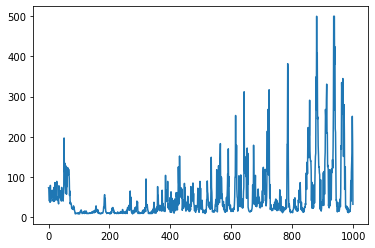

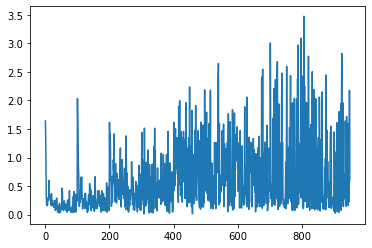

In [5]:
agent = DQN(env=env, 
            buffersize=20000,
            gamma=0.95,
            batch_size=32, 
            lr=5e-3,
            update_target_freq=100,
            seed=42
            )
agent.play(1000)

In [6]:
len(agent.buffer)

20000